In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score

2023-03-11 22:09:21.519822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 22:09:22.327460: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-11 22:09:23.860867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mmey/miniconda3/envs/wsl-tf/lib/
2023-03-11 22:09:23.861085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1278448984055164283
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22655533056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 938305792769846547
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-03-11 22:09:26.062895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 22:09:26.334242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:26.403887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:26.403985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-03-11 22:09:30.384903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:30.385139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:30.385310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
import ipywidgets as widgets
import io
import os
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

X_train = []
y_train = []
image_size = 128

In [5]:
train_path = 'data/Training'
labels = os.listdir(train_path)
print(labels)

['pituitary', 'glioma', 'meningioma']


## Get all the data and label them

In [6]:
for i in labels:
    folder_path = os.path.join(train_path, i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, j))
        img = cv2.resize(img, (image_size, image_size))
        
        X_train.append(img)
        y_train.append(i)

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [8]:
X_train.shape, y_train.shape


((3064, 128, 128, 3), (3064,))

### Shuffle data

In [9]:
X_train, y_train = shuffle(X_train, y_train, random_state = 99)
X_train.shape, y_train.shape

((3064, 128, 128, 3), (3064,))

### Train-test-split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 100)

### Turn labels into number format

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))

y_train_new[:5]

[2, 2, 0, 1, 0]

In [12]:
y_train_new = tf.keras.utils.to_categorical(y_train_new)
y_train_new

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [13]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))

y_test_new = tf.keras.utils.to_categorical(y_test_new)
y_test_new

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

### Build CNN Model with K-Fold

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(3, activation = 'softmax'))

2023-03-11 22:09:43.091908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:43.092094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:43.092161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:43.092572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 22:09:43.092597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not ident

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        36928     
                                                        

In [17]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [19]:
model.metrics_names

[]

In [20]:
hist = model.fit(X_train, y_train_new, epochs = 20, validation_split = 0.2)

Epoch 1/20


2023-03-11 22:10:30.228974: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-11 22:10:35.785358: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-11 22:10:35.907591: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-11 22:10:35.907678: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-11 22:10:36.038854: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-11 22:10:36.039104: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-11 22:10:40.514707: I tensorflow/stream_executor/cuda/c

62/62 [==============================] - 20s 43ms/step - loss: 1.3156 - accuracy: 0.4434 - val_loss: 0.9625 - val_accuracy: 0.5540
Epoch 2/20
62/62 [==============================] - 2s 29ms/step - loss: 0.8143 - accuracy: 0.6393 - val_loss: 0.8568 - val_accuracy: 0.6843
Epoch 3/20
62/62 [==============================] - 2s 29ms/step - loss: 0.6983 - accuracy: 0.6740 - val_loss: 0.6227 - val_accuracy: 0.7312
Epoch 4/20
62/62 [==============================] - 2s 29ms/step - loss: 0.6037 - accuracy: 0.7230 - val_loss: 0.6771 - val_accuracy: 0.6986
Epoch 5/20
62/62 [==============================] - 2s 29ms/step - loss: 0.5624 - accuracy: 0.7362 - val_loss: 0.5647 - val_accuracy: 0.7312
Epoch 6/20
62/62 [==============================] - 2s 28ms/step - loss: 0.4983 - accuracy: 0.7714 - val_loss: 0.5085 - val_accuracy: 0.7495
Epoch 7/20
62/62 [==============================] - 2s 29ms/step - loss: 0.4678 - accuracy: 0.7816 - val_loss: 0.5331 - val_accuracy: 0.7515
Epoch 8/20
62/62 [=====

In [22]:
model.metrics_names[1]

'accuracy'

In [22]:
tf.keras.backend.clear_session()

In [23]:
model.save("vanilla_bt_classification.h5")

In [24]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy'] 

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

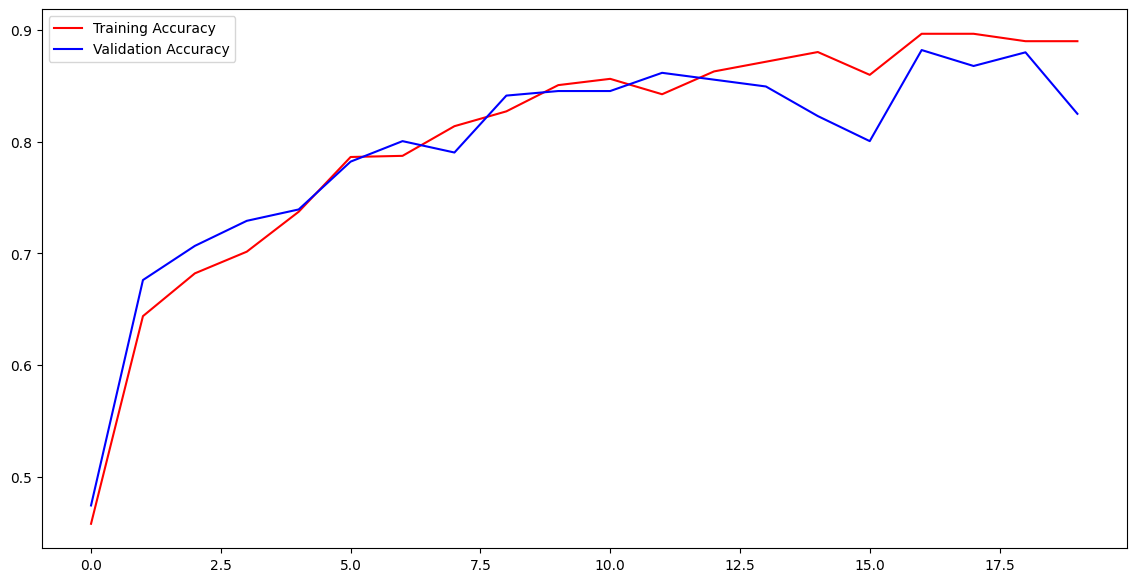

In [30]:
epochs = range(len(acc))
fig = plt.figure(figsize = (14,7))
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.legend(loc = 'upper left')
plt.show()

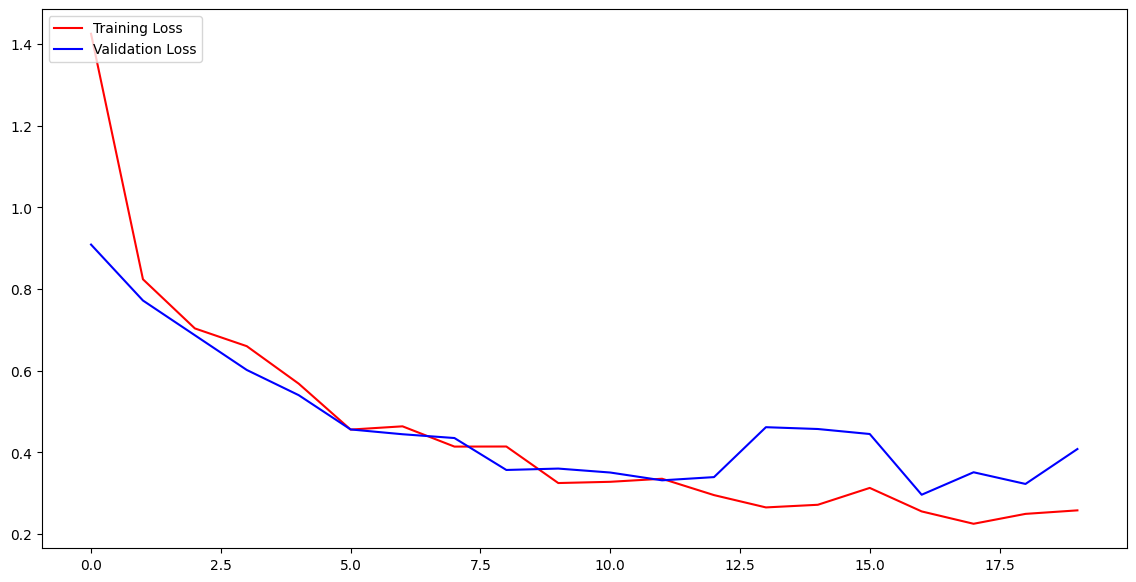

In [31]:
loss = hist.history['loss']
val_loss = hist.history['val_loss'] 

epochs = range(len(acc))
fig = plt.figure(figsize = (14,7))
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.show()

In [33]:
X_test.shape

(613, 128, 128, 3)

In [34]:
y_test.shape

(613,)

In [57]:
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [54]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

### Convert y_test data to numerical for evaluation

In [67]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))

In [80]:
acc = accuracy_score(y_test_new, yhat_classes)
precision = precision_score(y_test_new, yhat_classes, average='weighted')
recall = recall_score(y_test_new, yhat_classes, average='weighted')
f1 = f1_score(y_test_new, yhat_classes, average='weighted')

In [81]:
print('Accuracy: {0} | Precision: {1} | Recall: {2} | F1: {3}'.format(acc, precision, recall, f1))

Accuracy: 0.833605220228385 | Precision: 0.8391347719181992 | Recall: 0.833605220228385 | F1: 0.8146020321423321


In [82]:
confusion_matrix(y_test_new, yhat_classes)

array([[167,   7,   0],
       [  4, 285,   9],
       [ 20,  62,  59]])